<a href="https://colab.research.google.com/github/akurniawan/ICS5110-final/blob/main/01-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import re
import math
import nltk
import numpy as np
import spacy
import seaborn as sns

from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from collections import Counter
from matplotlib import pyplot
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm

In [18]:
tqdm.pandas()

/Users/akurniawan/opt/miniconda3/envs/ics5110/lib/python3.8/site-packages/tqdm/std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
review_df = pd.read_csv("yelp_review_sentiment_raw.csv", delimiter="\t")

In [3]:
review_df.head()

,review_id,stars,useful,date,text
0,xQY8N_XvtGbearJ5X4QryQ,2.0,5,2015-04-15 05:21:16,"As someone who has worked with many museums, I..."
1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,1,2013-12-07 03:16:52,I am actually horrified this place is still in...
2,LG2ZaYiOgpr2DK_90pYjNw,5.0,1,2015-12-05 03:18:11,I love Deagan's. I do. I really do. The atmosp...
3,i6g_oA9Yf9Y31qt0wibXpw,1.0,0,2011-05-27 05:30:52,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,6TdNDKywdbjoTkizeMce8A,4.0,0,2017-01-14 21:56:57,"Oh happy day, finally have a Canes near my cas..."


In [4]:
review_df.count()

review_id    8021122
stars        8021122
useful       8021122
date         8021122
text         8021120
dtype: int64

In [5]:
review_df["date"] = review_df["date"].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [6]:
# Filter by year to only get a sort of fresh data to prevent language diversion
review_df = review_df[review_df["date"].dt.year >= 2017]
review_df.head()

,review_id,stars,useful,date,text
4,6TdNDKywdbjoTkizeMce8A,4.0,0,2017-01-14 21:56:57,"Oh happy day, finally have a Canes near my cas..."
7,lpFIJYpsvDxyph-kPzZ6aA,5.0,0,2017-07-18 18:31:54,"Awesome office and staff, very professional an..."
15,mjbs5CL4eMu4o6_VtYhN3Q,1.0,0,2017-08-07 21:36:36,"If I could give less than one star, that would..."
17,Ne_2CSfcKIqXHmv_KC0uqg,4.0,3,2018-02-01 19:15:00,A close friend was in town and so instead of t...
18,Hy-gUXQh3RVhE8FLH9Dt4Q,1.0,0,2017-06-28 00:39:18,Tried to have my car repaired. Even made an a...


In [7]:
review_df.count()

review_id    3751182
stars        3751182
useful       3751182
date         3751182
text         3751182
dtype: int64

In [8]:
def bin_fn(x):
    if 0 <= x < 3:
        return "bad"
    elif 3 <= x <= 5:
        return "good"

review_df["sentiment"] = review_df["stars"].apply(bin_fn)
review_df.head()

,review_id,stars,useful,date,text,sentiment
4,6TdNDKywdbjoTkizeMce8A,4.0,0,2017-01-14 21:56:57,"Oh happy day, finally have a Canes near my cas...",good
7,lpFIJYpsvDxyph-kPzZ6aA,5.0,0,2017-07-18 18:31:54,"Awesome office and staff, very professional an...",good
15,mjbs5CL4eMu4o6_VtYhN3Q,1.0,0,2017-08-07 21:36:36,"If I could give less than one star, that would...",bad
17,Ne_2CSfcKIqXHmv_KC0uqg,4.0,3,2018-02-01 19:15:00,A close friend was in town and so instead of t...,good
18,Hy-gUXQh3RVhE8FLH9Dt4Q,1.0,0,2017-06-28 00:39:18,Tried to have my car repaired. Even made an a...,bad


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

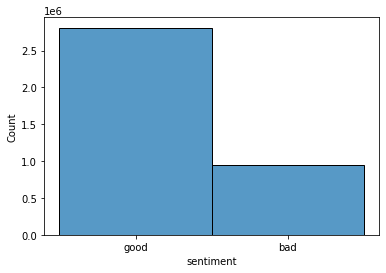

In [9]:
sns.histplot(review_df, x="sentiment")

In [10]:
total_data = 800000
good_df = review_df[review_df["sentiment"] == "good"].sample(n=total_data)
quite_good_df = review_df[review_df["sentiment"] == "quite good"]
kind_bad_df = review_df[review_df["sentiment"] == "kind of bad"]
bad_df = review_df[review_df["sentiment"] == "bad"].sample(n=total_data)

df = pd.concat([good_df, quite_good_df, kind_bad_df, bad_df])
df = df.sample(frac=1).reset_index(drop=True)
df.count()

review_id    1600000
stars        1600000
useful       1600000
date         1600000
text         1600000
sentiment    1600000
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

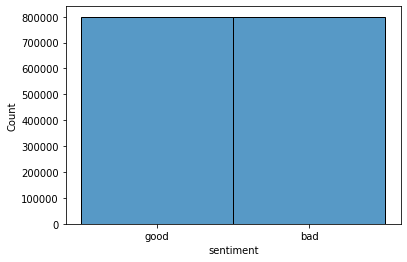

In [11]:
sns.histplot(df, x="sentiment")

In [15]:
sampled_df = df.sample(n=250000, random_state=42)

In [19]:
nlp = spacy.load("en", disable=["parser", "ner"])


def lemmatize(text):
    doc = nlp(text)
    lem = []
    for token in doc:
        lem.append(token.lemma_)
    return " ".join(lem)

def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_newline(text):
    pattern = r'(\n)+'
    text = re.sub(pattern, '', text)
    pattern = r'(\r)+'
    text = re.sub(pattern, '', text)
    pattern = r'(\r\n)+'
    text = re.sub(pattern, '', text)
    return text

def remove_multiple_whitespaces(text):
    pattern = r' {2,}'
    text = re.sub(pattern, ' ', text)
    pattern1 = r"\t+"
    text = re.sub(pattern1, ' ', text)
    return text

def preprocessing(text):
    text = str(text).strip().lower()
    text = remove_special_characters(text)
    text = remove_newline(text)
    text = remove_multiple_whitespaces(text)
    text = lemmatize(text)
    return text

sampled_df["text"] = sampled_df["text"].progress_apply(preprocessing)

100%|██████████| 250000/250000 [22:09<00:00, 188.10it/s]


In [20]:
sampled_df.head()

,review_id,stars,useful,date,text,sentiment
541200,WISlUBSSWTTLe8MxraWbRQ,1.0,0,2017-03-27 19:07:34,i recently discover that jiffy lube do not cha...,bad
750,fbkeIKtIPQ5IingxK-klEQ,5.0,0,2017-12-20 03:14:36,calgary just get an amazing yoga instructor -P...,good
766711,sJlElhU1mzQvC-WPxOtDmQ,1.0,3,2018-11-14 18:16:46,the doctor here be so good that management fee...,bad
285055,KtSuj5digrHEoy_WqO7mPw,2.0,0,2017-09-04 03:50:44,i get to first say that -PRON- past review of ...,bad
705995,-ZQb5dKis_R2tnOLYUyDKA,1.0,2,2018-06-25 15:20:29,yike this place be horrific i go in a month ag...,bad


In [21]:
sampled_df[["review_id", "stars", "date", "text", "sentiment"]].to_csv("yelp_review_sentiment_2classes.tsv", sep="\t")